In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1377693, 828)
(1377693, 8)
validation
(248981, 828)
(248981, 8)
test
(138861, 828)
(138861, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/138 [..............................] - ETA: 3:42 - loss: 2.1654 - STD: 0.0480 - MAE: 0.2182

  4/138 [..............................] - ETA: 3s - loss: 2.0936 - STD: 0.0461 - MAE: 0.2167  

  6/138 [>.............................] - ETA: 3s - loss: 2.0857 - STD: 0.0448 - MAE: 0.2166

  9/138 [>.............................] - ETA: 2s - loss: 2.0739 - STD: 0.0415 - MAE: 0.2166

 12/138 [=>............................] - ETA: 2s - loss: 2.0679 - STD: 0.0391 - MAE: 0.2166

 15/138 [==>...........................] - ETA: 2s - loss: 2.0608 - STD: 0.0379 - MAE: 0.2164

 18/138 [==>...........................] - ETA: 2s - loss: 2.0512 - STD: 0.0375 - MAE: 0.2161

 21/138 [===>..........................] - ETA: 2s - loss: 2.0404 - STD: 0.0385 - MAE: 0.2156

 24/138 [====>.........................] - ETA: 2s - loss: 2.0278 - STD: 0.0407 - MAE: 0.2149

 27/138 [====>.........................] - ETA: 2s - loss: 2.0151 - STD: 0.0441 - MAE: 0.2140

 30/138 [=====>........................] - ETA: 2s - loss: 2.0026 - STD: 0.0470 - MAE: 0.2132

 33/138 [======>.......................] - ETA: 2s - loss: 1.9904 - STD: 0.0496 - MAE: 0.2125

 36/138 [======>.......................] - ETA: 2s - loss: 1.9776 - STD: 0.0522 - MAE: 0.2117

 39/138 [=======>......................] - ETA: 2s - loss: 1.9657 - STD: 0.0546 - MAE: 0.2110

 42/138 [========>.....................] - ETA: 2s - loss: 1.9530 - STD: 0.0568 - MAE: 0.2103

 45/138 [========>.....................] - ETA: 2s - loss: 1.9402 - STD: 0.0593 - MAE: 0.2095

 48/138 [=========>....................] - ETA: 2s - loss: 1.9268 - STD: 0.0615 - MAE: 0.2087

 51/138 [==========>...................] - ETA: 1s - loss: 1.9125 - STD: 0.0636 - MAE: 0.2079

 54/138 [==========>...................] - ETA: 1s - loss: 1.8970 - STD: 0.0658 - MAE: 0.2071

 57/138 [===========>..................] - ETA: 1s - loss: 1.8809 - STD: 0.0680 - MAE: 0.2062

 60/138 [============>.................] - ETA: 1s - loss: 1.8646 - STD: 0.0702 - MAE: 0.2053

 63/138 [============>.................] - ETA: 1s - loss: 1.8489 - STD: 0.0726 - MAE: 0.2044

 66/138 [=============>................] - ETA: 1s - loss: 1.8332 - STD: 0.0749 - MAE: 0.2034

 69/138 [==============>...............] - ETA: 1s - loss: 1.8179 - STD: 0.0772 - MAE: 0.2024

 72/138 [==============>...............] - ETA: 1s - loss: 1.8032 - STD: 0.0795 - MAE: 0.2015

 75/138 [===============>..............] - ETA: 1s - loss: 1.7889 - STD: 0.0818 - MAE: 0.2006

 78/138 [===============>..............] - ETA: 1s - loss: 1.7746 - STD: 0.0840 - MAE: 0.1996

 81/138 [================>.............] - ETA: 1s - loss: 1.7611 - STD: 0.0863 - MAE: 0.1986

 84/138 [=================>............] - ETA: 1s - loss: 1.7482 - STD: 0.0884 - MAE: 0.1977

 87/138 [=================>............] - ETA: 1s - loss: 1.7366 - STD: 0.0905 - MAE: 0.1968

 90/138 [==================>...........] - ETA: 1s - loss: 1.7247 - STD: 0.0926 - MAE: 0.1959

 93/138 [===================>..........] - ETA: 1s - loss: 1.7132 - STD: 0.0945 - MAE: 0.1950

 96/138 [===================>..........] - ETA: 1s - loss: 1.7025 - STD: 0.0964 - MAE: 0.1942

 99/138 [====================>.........] - ETA: 1s - loss: 1.6922 - STD: 0.0982 - MAE: 0.1934

102/138 [=====================>........] - ETA: 1s - loss: 1.6825 - STD: 0.0999 - MAE: 0.1927

105/138 [=====================>........] - ETA: 1s - loss: 1.6730 - STD: 0.1016 - MAE: 0.1920

108/138 [======================>.......] - ETA: 0s - loss: 1.6638 - STD: 0.1031 - MAE: 0.1913

111/138 [=======================>......] - ETA: 0s - loss: 1.6550 - STD: 0.1046 - MAE: 0.1906

114/138 [=======================>......] - ETA: 0s - loss: 1.6465 - STD: 0.1061 - MAE: 0.1899

117/138 [========================>.....] - ETA: 0s - loss: 1.6387 - STD: 0.1075 - MAE: 0.1893

120/138 [=========================>....] - ETA: 0s - loss: 1.6309 - STD: 0.1088 - MAE: 0.1887

123/138 [=========================>....] - ETA: 0s - loss: 1.6234 - STD: 0.1101 - MAE: 0.1881

126/138 [==========================>...] - ETA: 0s - loss: 1.6163 - STD: 0.1113 - MAE: 0.1876

129/138 [===========================>..] - ETA: 0s - loss: 1.6093 - STD: 0.1125 - MAE: 0.1870

132/138 [===========================>..] - ETA: 0s - loss: 1.6025 - STD: 0.1136 - MAE: 0.1865

135/138 [============================>.] - ETA: 0s - loss: 1.5962 - STD: 0.1148 - MAE: 0.1860

138/138 [==============================] - ETA: 0s - loss: 1.5902 - STD: 0.1158 - MAE: 0.1855

138/138 [==============================] - 7s 39ms/step - loss: 1.5902 - STD: 0.1158 - MAE: 0.1855 - val_loss: 1.4277 - val_STD: 0.1657 - val_MAE: 0.1669


Epoch 2/10000


  1/138 [..............................] - ETA: 6s - loss: 1.3167 - STD: 0.1652 - MAE: 0.1634

  4/138 [..............................] - ETA: 3s - loss: 1.3093 - STD: 0.1646 - MAE: 0.1632

  7/138 [>.............................] - ETA: 2s - loss: 1.3069 - STD: 0.1645 - MAE: 0.1630

 10/138 [=>............................] - ETA: 2s - loss: 1.3054 - STD: 0.1652 - MAE: 0.1628

 13/138 [=>............................] - ETA: 2s - loss: 1.3051 - STD: 0.1653 - MAE: 0.1627

 16/138 [==>...........................] - ETA: 2s - loss: 1.3040 - STD: 0.1657 - MAE: 0.1625

 19/138 [===>..........................] - ETA: 2s - loss: 1.3040 - STD: 0.1659 - MAE: 0.1624

 22/138 [===>..........................] - ETA: 2s - loss: 1.3015 - STD: 0.1661 - MAE: 0.1623

 25/138 [====>.........................] - ETA: 2s - loss: 1.3007 - STD: 0.1661 - MAE: 0.1622

 28/138 [=====>........................] - ETA: 2s - loss: 1.2976 - STD: 0.1664 - MAE: 0.1620

 31/138 [=====>........................] - ETA: 2s - loss: 1.2945 - STD: 0.1666 - MAE: 0.1618

 34/138 [======>.......................] - ETA: 2s - loss: 1.2926 - STD: 0.1668 - MAE: 0.1616

 37/138 [=======>......................] - ETA: 2s - loss: 1.2912 - STD: 0.1670 - MAE: 0.1615

 40/138 [=======>......................] - ETA: 2s - loss: 1.2903 - STD: 0.1673 - MAE: 0.1613

 43/138 [========>.....................] - ETA: 2s - loss: 1.2891 - STD: 0.1675 - MAE: 0.1612

 46/138 [=========>....................] - ETA: 2s - loss: 1.2880 - STD: 0.1677 - MAE: 0.1611

 49/138 [=========>....................] - ETA: 2s - loss: 1.2862 - STD: 0.1679 - MAE: 0.1610

 52/138 [==========>...................] - ETA: 1s - loss: 1.2847 - STD: 0.1681 - MAE: 0.1608

 55/138 [==========>...................] - ETA: 1s - loss: 1.2838 - STD: 0.1683 - MAE: 0.1607

 58/138 [===========>..................] - ETA: 1s - loss: 1.2820 - STD: 0.1685 - MAE: 0.1605

 61/138 [============>.................] - ETA: 1s - loss: 1.2807 - STD: 0.1687 - MAE: 0.1604

 64/138 [============>.................] - ETA: 1s - loss: 1.2790 - STD: 0.1690 - MAE: 0.1602

 67/138 [=============>................] - ETA: 1s - loss: 1.2781 - STD: 0.1692 - MAE: 0.1601

 70/138 [==============>...............] - ETA: 1s - loss: 1.2769 - STD: 0.1693 - MAE: 0.1600

 73/138 [==============>...............] - ETA: 1s - loss: 1.2758 - STD: 0.1695 - MAE: 0.1599

 76/138 [===============>..............] - ETA: 1s - loss: 1.2744 - STD: 0.1696 - MAE: 0.1598

 79/138 [================>.............] - ETA: 1s - loss: 1.2732 - STD: 0.1698 - MAE: 0.1596

 82/138 [================>.............] - ETA: 1s - loss: 1.2721 - STD: 0.1700 - MAE: 0.1595

 85/138 [=================>............] - ETA: 1s - loss: 1.2707 - STD: 0.1702 - MAE: 0.1594

 88/138 [==================>...........] - ETA: 1s - loss: 1.2694 - STD: 0.1704 - MAE: 0.1593

 91/138 [==================>...........] - ETA: 1s - loss: 1.2682 - STD: 0.1706 - MAE: 0.1591

 94/138 [===================>..........] - ETA: 1s - loss: 1.2670 - STD: 0.1708 - MAE: 0.1590

 97/138 [====================>.........] - ETA: 0s - loss: 1.2654 - STD: 0.1710 - MAE: 0.1589

100/138 [====================>.........] - ETA: 0s - loss: 1.2637 - STD: 0.1712 - MAE: 0.1587

103/138 [=====================>........] - ETA: 0s - loss: 1.2618 - STD: 0.1714 - MAE: 0.1586

106/138 [======================>.......] - ETA: 0s - loss: 1.2603 - STD: 0.1716 - MAE: 0.1584

109/138 [======================>.......] - ETA: 0s - loss: 1.2590 - STD: 0.1717 - MAE: 0.1583

112/138 [=======================>......] - ETA: 0s - loss: 1.2573 - STD: 0.1719 - MAE: 0.1582

115/138 [========================>.....] - ETA: 0s - loss: 1.2556 - STD: 0.1720 - MAE: 0.1580

118/138 [========================>.....] - ETA: 0s - loss: 1.2543 - STD: 0.1722 - MAE: 0.1579

121/138 [=========================>....] - ETA: 0s - loss: 1.2532 - STD: 0.1724 - MAE: 0.1578

124/138 [=========================>....] - ETA: 0s - loss: 1.2517 - STD: 0.1726 - MAE: 0.1577

127/138 [==========================>...] - ETA: 0s - loss: 1.2502 - STD: 0.1728 - MAE: 0.1575

130/138 [===========================>..] - ETA: 0s - loss: 1.2487 - STD: 0.1730 - MAE: 0.1574

133/138 [===========================>..] - ETA: 0s - loss: 1.2479 - STD: 0.1732 - MAE: 0.1573

136/138 [============================>.] - ETA: 0s - loss: 1.2465 - STD: 0.1734 - MAE: 0.1571

138/138 [==============================] - 4s 26ms/step - loss: 1.2457 - STD: 0.1735 - MAE: 0.1571 - val_loss: 1.2887 - val_STD: 0.1860 - val_MAE: 0.1530


Epoch 3/10000


  1/138 [..............................] - ETA: 6s - loss: 1.1928 - STD: 0.1824 - MAE: 0.1513

  4/138 [..............................] - ETA: 3s - loss: 1.1815 - STD: 0.1814 - MAE: 0.1510

  7/138 [>.............................] - ETA: 2s - loss: 1.1776 - STD: 0.1815 - MAE: 0.1509

 10/138 [=>............................] - ETA: 2s - loss: 1.1718 - STD: 0.1820 - MAE: 0.1504

 13/138 [=>............................] - ETA: 2s - loss: 1.1718 - STD: 0.1824 - MAE: 0.1503

 16/138 [==>...........................] - ETA: 2s - loss: 1.1697 - STD: 0.1826 - MAE: 0.1501

 19/138 [===>..........................] - ETA: 2s - loss: 1.1671 - STD: 0.1829 - MAE: 0.1498

 22/138 [===>..........................] - ETA: 2s - loss: 1.1672 - STD: 0.1832 - MAE: 0.1497

 25/138 [====>.........................] - ETA: 2s - loss: 1.1650 - STD: 0.1834 - MAE: 0.1495

 28/138 [=====>........................] - ETA: 2s - loss: 1.1650 - STD: 0.1837 - MAE: 0.1494

 31/138 [=====>........................] - ETA: 2s - loss: 1.1647 - STD: 0.1839 - MAE: 0.1493

 34/138 [======>.......................] - ETA: 2s - loss: 1.1639 - STD: 0.1841 - MAE: 0.1493

 37/138 [=======>......................] - ETA: 2s - loss: 1.1618 - STD: 0.1844 - MAE: 0.1490

 40/138 [=======>......................] - ETA: 2s - loss: 1.1604 - STD: 0.1846 - MAE: 0.1489

 43/138 [========>.....................] - ETA: 2s - loss: 1.1604 - STD: 0.1848 - MAE: 0.1488

 46/138 [=========>....................] - ETA: 2s - loss: 1.1603 - STD: 0.1850 - MAE: 0.1488

 49/138 [=========>....................] - ETA: 2s - loss: 1.1588 - STD: 0.1851 - MAE: 0.1487

 52/138 [==========>...................] - ETA: 1s - loss: 1.1578 - STD: 0.1852 - MAE: 0.1486

 55/138 [==========>...................] - ETA: 1s - loss: 1.1557 - STD: 0.1853 - MAE: 0.1484

 58/138 [===========>..................] - ETA: 1s - loss: 1.1543 - STD: 0.1854 - MAE: 0.1483

 61/138 [============>.................] - ETA: 1s - loss: 1.1527 - STD: 0.1856 - MAE: 0.1481

 64/138 [============>.................] - ETA: 1s - loss: 1.1514 - STD: 0.1857 - MAE: 0.1480

 67/138 [=============>................] - ETA: 1s - loss: 1.1499 - STD: 0.1859 - MAE: 0.1479

 70/138 [==============>...............] - ETA: 1s - loss: 1.1485 - STD: 0.1861 - MAE: 0.1478

 73/138 [==============>...............] - ETA: 1s - loss: 1.1476 - STD: 0.1862 - MAE: 0.1477

 76/138 [===============>..............] - ETA: 1s - loss: 1.1462 - STD: 0.1864 - MAE: 0.1475

 79/138 [================>.............] - ETA: 1s - loss: 1.1453 - STD: 0.1865 - MAE: 0.1474

 82/138 [================>.............] - ETA: 1s - loss: 1.1438 - STD: 0.1867 - MAE: 0.1473

 85/138 [=================>............] - ETA: 1s - loss: 1.1420 - STD: 0.1869 - MAE: 0.1471

 88/138 [==================>...........] - ETA: 1s - loss: 1.1406 - STD: 0.1870 - MAE: 0.1470

 91/138 [==================>...........] - ETA: 1s - loss: 1.1397 - STD: 0.1872 - MAE: 0.1469

 94/138 [===================>..........] - ETA: 0s - loss: 1.1383 - STD: 0.1873 - MAE: 0.1467

 97/138 [====================>.........] - ETA: 0s - loss: 1.1370 - STD: 0.1875 - MAE: 0.1466

100/138 [====================>.........] - ETA: 0s - loss: 1.1361 - STD: 0.1877 - MAE: 0.1465

103/138 [=====================>........] - ETA: 0s - loss: 1.1359 - STD: 0.1879 - MAE: 0.1464

106/138 [======================>.......] - ETA: 0s - loss: 1.1350 - STD: 0.1880 - MAE: 0.1463

109/138 [======================>.......] - ETA: 0s - loss: 1.1337 - STD: 0.1881 - MAE: 0.1462

112/138 [=======================>......] - ETA: 0s - loss: 1.1328 - STD: 0.1882 - MAE: 0.1461

115/138 [========================>.....] - ETA: 0s - loss: 1.1320 - STD: 0.1884 - MAE: 0.1460

118/138 [========================>.....] - ETA: 0s - loss: 1.1310 - STD: 0.1886 - MAE: 0.1459

121/138 [=========================>....] - ETA: 0s - loss: 1.1302 - STD: 0.1887 - MAE: 0.1458

124/138 [=========================>....] - ETA: 0s - loss: 1.1291 - STD: 0.1889 - MAE: 0.1457

127/138 [==========================>...] - ETA: 0s - loss: 1.1279 - STD: 0.1890 - MAE: 0.1455

130/138 [===========================>..] - ETA: 0s - loss: 1.1269 - STD: 0.1891 - MAE: 0.1454

133/138 [===========================>..] - ETA: 0s - loss: 1.1256 - STD: 0.1892 - MAE: 0.1453

136/138 [============================>.] - ETA: 0s - loss: 1.1247 - STD: 0.1894 - MAE: 0.1452

138/138 [==============================] - 4s 26ms/step - loss: 1.1238 - STD: 0.1894 - MAE: 0.1451 - val_loss: 1.2477 - val_STD: 0.2001 - val_MAE: 0.1450


Epoch 4/10000


  1/138 [..............................] - ETA: 5s - loss: 1.0846 - STD: 0.1951 - MAE: 0.1406

  4/138 [..............................] - ETA: 3s - loss: 1.0776 - STD: 0.1963 - MAE: 0.1399

  7/138 [>.............................] - ETA: 2s - loss: 1.0762 - STD: 0.1966 - MAE: 0.1398

 10/138 [=>............................] - ETA: 2s - loss: 1.0709 - STD: 0.1965 - MAE: 0.1395

 13/138 [=>............................] - ETA: 2s - loss: 1.0679 - STD: 0.1965 - MAE: 0.1393

 16/138 [==>...........................] - ETA: 2s - loss: 1.0652 - STD: 0.1967 - MAE: 0.1390

 19/138 [===>..........................] - ETA: 2s - loss: 1.0659 - STD: 0.1968 - MAE: 0.1391

 22/138 [===>..........................] - ETA: 2s - loss: 1.0698 - STD: 0.1969 - MAE: 0.1393

 25/138 [====>.........................] - ETA: 2s - loss: 1.0708 - STD: 0.1969 - MAE: 0.1393

 28/138 [=====>........................] - ETA: 2s - loss: 1.0713 - STD: 0.1970 - MAE: 0.1393

 31/138 [=====>........................] - ETA: 2s - loss: 1.0712 - STD: 0.1971 - MAE: 0.1393

 34/138 [======>.......................] - ETA: 2s - loss: 1.0711 - STD: 0.1973 - MAE: 0.1392

 37/138 [=======>......................] - ETA: 2s - loss: 1.0714 - STD: 0.1973 - MAE: 0.1392

 40/138 [=======>......................] - ETA: 2s - loss: 1.0712 - STD: 0.1973 - MAE: 0.1392

 43/138 [========>.....................] - ETA: 2s - loss: 1.0702 - STD: 0.1974 - MAE: 0.1391

 46/138 [=========>....................] - ETA: 2s - loss: 1.0694 - STD: 0.1975 - MAE: 0.1390

 49/138 [=========>....................] - ETA: 2s - loss: 1.0688 - STD: 0.1976 - MAE: 0.1390

 52/138 [==========>...................] - ETA: 1s - loss: 1.0685 - STD: 0.1977 - MAE: 0.1389

 55/138 [==========>...................] - ETA: 1s - loss: 1.0668 - STD: 0.1978 - MAE: 0.1388

 58/138 [===========>..................] - ETA: 1s - loss: 1.0656 - STD: 0.1978 - MAE: 0.1387

 61/138 [============>.................] - ETA: 1s - loss: 1.0648 - STD: 0.1979 - MAE: 0.1386

 64/138 [============>.................] - ETA: 1s - loss: 1.0633 - STD: 0.1980 - MAE: 0.1385

 67/138 [=============>................] - ETA: 1s - loss: 1.0625 - STD: 0.1981 - MAE: 0.1384

 70/138 [==============>...............] - ETA: 1s - loss: 1.0616 - STD: 0.1982 - MAE: 0.1383

 73/138 [==============>...............] - ETA: 1s - loss: 1.0614 - STD: 0.1983 - MAE: 0.1383

 76/138 [===============>..............] - ETA: 1s - loss: 1.0610 - STD: 0.1984 - MAE: 0.1382

 79/138 [================>.............] - ETA: 1s - loss: 1.0606 - STD: 0.1986 - MAE: 0.1381

 82/138 [================>.............] - ETA: 1s - loss: 1.0594 - STD: 0.1987 - MAE: 0.1380

 85/138 [=================>............] - ETA: 1s - loss: 1.0586 - STD: 0.1988 - MAE: 0.1379

 88/138 [==================>...........] - ETA: 1s - loss: 1.0579 - STD: 0.1988 - MAE: 0.1379

 91/138 [==================>...........] - ETA: 1s - loss: 1.0567 - STD: 0.1989 - MAE: 0.1378

 94/138 [===================>..........] - ETA: 0s - loss: 1.0559 - STD: 0.1990 - MAE: 0.1377

 97/138 [====================>.........] - ETA: 0s - loss: 1.0552 - STD: 0.1992 - MAE: 0.1376

100/138 [====================>.........] - ETA: 0s - loss: 1.0545 - STD: 0.1992 - MAE: 0.1375

103/138 [=====================>........] - ETA: 0s - loss: 1.0535 - STD: 0.1993 - MAE: 0.1374

106/138 [======================>.......] - ETA: 0s - loss: 1.0532 - STD: 0.1994 - MAE: 0.1374

109/138 [======================>.......] - ETA: 0s - loss: 1.0525 - STD: 0.1995 - MAE: 0.1373

112/138 [=======================>......] - ETA: 0s - loss: 1.0514 - STD: 0.1996 - MAE: 0.1372

115/138 [========================>.....] - ETA: 0s - loss: 1.0508 - STD: 0.1997 - MAE: 0.1371

118/138 [========================>.....] - ETA: 0s - loss: 1.0503 - STD: 0.1998 - MAE: 0.1371

121/138 [=========================>....] - ETA: 0s - loss: 1.0508 - STD: 0.1999 - MAE: 0.1371

124/138 [=========================>....] - ETA: 0s - loss: 1.0504 - STD: 0.2000 - MAE: 0.1370

127/138 [==========================>...] - ETA: 0s - loss: 1.0498 - STD: 0.2001 - MAE: 0.1369

130/138 [===========================>..] - ETA: 0s - loss: 1.0491 - STD: 0.2001 - MAE: 0.1369

133/138 [===========================>..] - ETA: 0s - loss: 1.0487 - STD: 0.2002 - MAE: 0.1368

136/138 [============================>.] - ETA: 0s - loss: 1.0485 - STD: 0.2003 - MAE: 0.1368

138/138 [==============================] - 4s 26ms/step - loss: 1.0480 - STD: 0.2004 - MAE: 0.1367 - val_loss: 1.2375 - val_STD: 0.2098 - val_MAE: 0.1402


Epoch 5/10000


  1/138 [..............................] - ETA: 6s - loss: 1.0234 - STD: 0.2044 - MAE: 0.1334

  4/138 [..............................] - ETA: 3s - loss: 1.0094 - STD: 0.2039 - MAE: 0.1329

  7/138 [>.............................] - ETA: 3s - loss: 1.0102 - STD: 0.2038 - MAE: 0.1330

 10/138 [=>............................] - ETA: 2s - loss: 1.0107 - STD: 0.2040 - MAE: 0.1330

 13/138 [=>............................] - ETA: 2s - loss: 1.0117 - STD: 0.2042 - MAE: 0.1331

 16/138 [==>...........................] - ETA: 2s - loss: 1.0121 - STD: 0.2044 - MAE: 0.1330

 19/138 [===>..........................] - ETA: 2s - loss: 1.0110 - STD: 0.2044 - MAE: 0.1330

 22/138 [===>..........................] - ETA: 2s - loss: 1.0101 - STD: 0.2046 - MAE: 0.1328

 25/138 [====>.........................] - ETA: 2s - loss: 1.0096 - STD: 0.2047 - MAE: 0.1328

 28/138 [=====>........................] - ETA: 2s - loss: 1.0103 - STD: 0.2048 - MAE: 0.1327

 31/138 [=====>........................] - ETA: 2s - loss: 1.0088 - STD: 0.2049 - MAE: 0.1326

 34/138 [======>.......................] - ETA: 2s - loss: 1.0096 - STD: 0.2050 - MAE: 0.1326

 37/138 [=======>......................] - ETA: 2s - loss: 1.0093 - STD: 0.2052 - MAE: 0.1325

 40/138 [=======>......................] - ETA: 2s - loss: 1.0092 - STD: 0.2053 - MAE: 0.1325

 43/138 [========>.....................] - ETA: 2s - loss: 1.0098 - STD: 0.2054 - MAE: 0.1325

 46/138 [=========>....................] - ETA: 2s - loss: 1.0099 - STD: 0.2055 - MAE: 0.1325

 49/138 [=========>....................] - ETA: 2s - loss: 1.0090 - STD: 0.2055 - MAE: 0.1324

 52/138 [==========>...................] - ETA: 1s - loss: 1.0084 - STD: 0.2056 - MAE: 0.1324

 55/138 [==========>...................] - ETA: 1s - loss: 1.0081 - STD: 0.2056 - MAE: 0.1323

 58/138 [===========>..................] - ETA: 1s - loss: 1.0074 - STD: 0.2056 - MAE: 0.1323

 61/138 [============>.................] - ETA: 1s - loss: 1.0064 - STD: 0.2057 - MAE: 0.1322

 64/138 [============>.................] - ETA: 1s - loss: 1.0055 - STD: 0.2058 - MAE: 0.1321

 67/138 [=============>................] - ETA: 1s - loss: 1.0050 - STD: 0.2059 - MAE: 0.1320

 70/138 [==============>...............] - ETA: 1s - loss: 1.0054 - STD: 0.2060 - MAE: 0.1320

 73/138 [==============>...............] - ETA: 1s - loss: 1.0050 - STD: 0.2060 - MAE: 0.1320

 76/138 [===============>..............] - ETA: 1s - loss: 1.0049 - STD: 0.2061 - MAE: 0.1319

 79/138 [================>.............] - ETA: 1s - loss: 1.0049 - STD: 0.2062 - MAE: 0.1319

 82/138 [================>.............] - ETA: 1s - loss: 1.0041 - STD: 0.2063 - MAE: 0.1318

 85/138 [=================>............] - ETA: 1s - loss: 1.0033 - STD: 0.2064 - MAE: 0.1317

 88/138 [==================>...........] - ETA: 1s - loss: 1.0028 - STD: 0.2065 - MAE: 0.1316

 91/138 [==================>...........] - ETA: 1s - loss: 1.0020 - STD: 0.2065 - MAE: 0.1316

 94/138 [===================>..........] - ETA: 0s - loss: 1.0015 - STD: 0.2066 - MAE: 0.1315

 97/138 [====================>.........] - ETA: 0s - loss: 1.0007 - STD: 0.2067 - MAE: 0.1314

100/138 [====================>.........] - ETA: 0s - loss: 1.0000 - STD: 0.2067 - MAE: 0.1314

103/138 [=====================>........] - ETA: 0s - loss: 0.9993 - STD: 0.2068 - MAE: 0.1313

106/138 [======================>.......] - ETA: 0s - loss: 1.0002 - STD: 0.2068 - MAE: 0.1313

109/138 [======================>.......] - ETA: 0s - loss: 1.0007 - STD: 0.2070 - MAE: 0.1313

112/138 [=======================>......] - ETA: 0s - loss: 1.0000 - STD: 0.2070 - MAE: 0.1312

115/138 [========================>.....] - ETA: 0s - loss: 0.9996 - STD: 0.2071 - MAE: 0.1312

118/138 [========================>.....] - ETA: 0s - loss: 0.9992 - STD: 0.2071 - MAE: 0.1312

121/138 [=========================>....] - ETA: 0s - loss: 0.9988 - STD: 0.2071 - MAE: 0.1311

124/138 [=========================>....] - ETA: 0s - loss: 0.9983 - STD: 0.2072 - MAE: 0.1311

127/138 [==========================>...] - ETA: 0s - loss: 0.9982 - STD: 0.2073 - MAE: 0.1310

130/138 [===========================>..] - ETA: 0s - loss: 0.9980 - STD: 0.2073 - MAE: 0.1310

133/138 [===========================>..] - ETA: 0s - loss: 0.9978 - STD: 0.2074 - MAE: 0.1310

136/138 [============================>.] - ETA: 0s - loss: 0.9973 - STD: 0.2075 - MAE: 0.1309

138/138 [==============================] - 4s 26ms/step - loss: 0.9969 - STD: 0.2075 - MAE: 0.1309 - val_loss: 1.2455 - val_STD: 0.2162 - val_MAE: 0.1379


Epoch 6/10000


  1/138 [..............................] - ETA: 6s - loss: 0.9629 - STD: 0.2107 - MAE: 0.1274

  4/138 [..............................] - ETA: 3s - loss: 0.9686 - STD: 0.2096 - MAE: 0.1284

  7/138 [>.............................] - ETA: 3s - loss: 0.9714 - STD: 0.2097 - MAE: 0.1285

 10/138 [=>............................] - ETA: 2s - loss: 0.9750 - STD: 0.2096 - MAE: 0.1288

 13/138 [=>............................] - ETA: 2s - loss: 0.9729 - STD: 0.2097 - MAE: 0.1286

 16/138 [==>...........................] - ETA: 2s - loss: 0.9715 - STD: 0.2100 - MAE: 0.1284

 19/138 [===>..........................] - ETA: 2s - loss: 0.9717 - STD: 0.2103 - MAE: 0.1283

 22/138 [===>..........................] - ETA: 2s - loss: 0.9701 - STD: 0.2104 - MAE: 0.1282

 25/138 [====>.........................] - ETA: 2s - loss: 0.9690 - STD: 0.2104 - MAE: 0.1281

 28/138 [=====>........................] - ETA: 2s - loss: 0.9674 - STD: 0.2105 - MAE: 0.1279

 31/138 [=====>........................] - ETA: 2s - loss: 0.9677 - STD: 0.2107 - MAE: 0.1279

 34/138 [======>.......................] - ETA: 2s - loss: 0.9672 - STD: 0.2108 - MAE: 0.1278

 37/138 [=======>......................] - ETA: 2s - loss: 0.9680 - STD: 0.2109 - MAE: 0.1278

 40/138 [=======>......................] - ETA: 2s - loss: 0.9681 - STD: 0.2110 - MAE: 0.1278

 43/138 [========>.....................] - ETA: 2s - loss: 0.9698 - STD: 0.2111 - MAE: 0.1279

 46/138 [=========>....................] - ETA: 2s - loss: 0.9702 - STD: 0.2111 - MAE: 0.1279

 49/138 [=========>....................] - ETA: 2s - loss: 0.9695 - STD: 0.2112 - MAE: 0.1278

 52/138 [==========>...................] - ETA: 1s - loss: 0.9685 - STD: 0.2113 - MAE: 0.1277

 55/138 [==========>...................] - ETA: 1s - loss: 0.9684 - STD: 0.2113 - MAE: 0.1277

 58/138 [===========>..................] - ETA: 1s - loss: 0.9693 - STD: 0.2114 - MAE: 0.1277

 61/138 [============>.................] - ETA: 1s - loss: 0.9684 - STD: 0.2114 - MAE: 0.1276

 64/138 [============>.................] - ETA: 1s - loss: 0.9678 - STD: 0.2115 - MAE: 0.1275

 67/138 [=============>................] - ETA: 1s - loss: 0.9675 - STD: 0.2116 - MAE: 0.1275

 70/138 [==============>...............] - ETA: 1s - loss: 0.9670 - STD: 0.2116 - MAE: 0.1275

 73/138 [==============>...............] - ETA: 1s - loss: 0.9675 - STD: 0.2116 - MAE: 0.1275

 76/138 [===============>..............] - ETA: 1s - loss: 0.9674 - STD: 0.2117 - MAE: 0.1275

 79/138 [================>.............] - ETA: 1s - loss: 0.9671 - STD: 0.2117 - MAE: 0.1274

 82/138 [================>.............] - ETA: 1s - loss: 0.9676 - STD: 0.2118 - MAE: 0.1274

 85/138 [=================>............] - ETA: 1s - loss: 0.9672 - STD: 0.2118 - MAE: 0.1274

 88/138 [==================>...........] - ETA: 1s - loss: 0.9667 - STD: 0.2119 - MAE: 0.1273

 91/138 [==================>...........] - ETA: 1s - loss: 0.9667 - STD: 0.2119 - MAE: 0.1273

 94/138 [===================>..........] - ETA: 0s - loss: 0.9662 - STD: 0.2119 - MAE: 0.1273

 97/138 [====================>.........] - ETA: 0s - loss: 0.9659 - STD: 0.2120 - MAE: 0.1272

100/138 [====================>.........] - ETA: 0s - loss: 0.9657 - STD: 0.2120 - MAE: 0.1272

103/138 [=====================>........] - ETA: 0s - loss: 0.9655 - STD: 0.2121 - MAE: 0.1272

106/138 [======================>.......] - ETA: 0s - loss: 0.9654 - STD: 0.2121 - MAE: 0.1271

109/138 [======================>.......] - ETA: 0s - loss: 0.9658 - STD: 0.2122 - MAE: 0.1271

112/138 [=======================>......] - ETA: 0s - loss: 0.9656 - STD: 0.2122 - MAE: 0.1271

115/138 [========================>.....] - ETA: 0s - loss: 0.9653 - STD: 0.2123 - MAE: 0.1271

118/138 [========================>.....] - ETA: 0s - loss: 0.9652 - STD: 0.2123 - MAE: 0.1271

121/138 [=========================>....] - ETA: 0s - loss: 0.9649 - STD: 0.2124 - MAE: 0.1270

124/138 [=========================>....] - ETA: 0s - loss: 0.9645 - STD: 0.2124 - MAE: 0.1270

127/138 [==========================>...] - ETA: 0s - loss: 0.9637 - STD: 0.2124 - MAE: 0.1269

130/138 [===========================>..] - ETA: 0s - loss: 0.9632 - STD: 0.2125 - MAE: 0.1269

133/138 [===========================>..] - ETA: 0s - loss: 0.9627 - STD: 0.2125 - MAE: 0.1268

136/138 [============================>.] - ETA: 0s - loss: 0.9624 - STD: 0.2125 - MAE: 0.1268

138/138 [==============================] - 4s 26ms/step - loss: 0.9618 - STD: 0.2125 - MAE: 0.1268 - val_loss: 1.3136 - val_STD: 0.2189 - val_MAE: 0.1403


Epoch 7/10000


  1/138 [..............................] - ETA: 6s - loss: 0.9699 - STD: 0.2125 - MAE: 0.1273

  4/138 [..............................] - ETA: 3s - loss: 0.9479 - STD: 0.2144 - MAE: 0.1250

  7/138 [>.............................] - ETA: 2s - loss: 0.9446 - STD: 0.2148 - MAE: 0.1248

 10/138 [=>............................] - ETA: 2s - loss: 0.9486 - STD: 0.2148 - MAE: 0.1251

 13/138 [=>............................] - ETA: 2s - loss: 0.9435 - STD: 0.2151 - MAE: 0.1247

 16/138 [==>...........................] - ETA: 2s - loss: 0.9422 - STD: 0.2152 - MAE: 0.1245

 19/138 [===>..........................] - ETA: 2s - loss: 0.9436 - STD: 0.2154 - MAE: 0.1245

 22/138 [===>..........................] - ETA: 2s - loss: 0.9431 - STD: 0.2154 - MAE: 0.1245

 25/138 [====>.........................] - ETA: 2s - loss: 0.9403 - STD: 0.2153 - MAE: 0.1244

 28/138 [=====>........................] - ETA: 2s - loss: 0.9393 - STD: 0.2153 - MAE: 0.1243

 31/138 [=====>........................] - ETA: 2s - loss: 0.9374 - STD: 0.2153 - MAE: 0.1241

 34/138 [======>.......................] - ETA: 2s - loss: 0.9372 - STD: 0.2154 - MAE: 0.1240

 37/138 [=======>......................] - ETA: 2s - loss: 0.9378 - STD: 0.2154 - MAE: 0.1241

 40/138 [=======>......................] - ETA: 2s - loss: 0.9381 - STD: 0.2154 - MAE: 0.1241

 43/138 [========>.....................] - ETA: 2s - loss: 0.9368 - STD: 0.2155 - MAE: 0.1240

 46/138 [=========>....................] - ETA: 2s - loss: 0.9368 - STD: 0.2156 - MAE: 0.1239

 49/138 [=========>....................] - ETA: 2s - loss: 0.9368 - STD: 0.2156 - MAE: 0.1239

 52/138 [==========>...................] - ETA: 1s - loss: 0.9363 - STD: 0.2156 - MAE: 0.1239

 55/138 [==========>...................] - ETA: 1s - loss: 0.9382 - STD: 0.2156 - MAE: 0.1240

 58/138 [===========>..................] - ETA: 1s - loss: 0.9396 - STD: 0.2157 - MAE: 0.1241

 61/138 [============>.................] - ETA: 1s - loss: 0.9415 - STD: 0.2158 - MAE: 0.1241

 64/138 [============>.................] - ETA: 1s - loss: 0.9416 - STD: 0.2158 - MAE: 0.1241

 67/138 [=============>................] - ETA: 1s - loss: 0.9417 - STD: 0.2158 - MAE: 0.1241

 70/138 [==============>...............] - ETA: 1s - loss: 0.9412 - STD: 0.2158 - MAE: 0.1241

 73/138 [==============>...............] - ETA: 1s - loss: 0.9417 - STD: 0.2158 - MAE: 0.1241

 76/138 [===============>..............] - ETA: 1s - loss: 0.9412 - STD: 0.2158 - MAE: 0.1241

 79/138 [================>.............] - ETA: 1s - loss: 0.9403 - STD: 0.2159 - MAE: 0.1240

 82/138 [================>.............] - ETA: 1s - loss: 0.9400 - STD: 0.2159 - MAE: 0.1240

 85/138 [=================>............] - ETA: 1s - loss: 0.9391 - STD: 0.2159 - MAE: 0.1239

 88/138 [==================>...........] - ETA: 1s - loss: 0.9382 - STD: 0.2160 - MAE: 0.1239

 91/138 [==================>...........] - ETA: 1s - loss: 0.9372 - STD: 0.2160 - MAE: 0.1238

 94/138 [===================>..........] - ETA: 0s - loss: 0.9366 - STD: 0.2160 - MAE: 0.1238

 97/138 [====================>.........] - ETA: 0s - loss: 0.9359 - STD: 0.2161 - MAE: 0.1237

100/138 [====================>.........] - ETA: 0s - loss: 0.9351 - STD: 0.2161 - MAE: 0.1236

103/138 [=====================>........] - ETA: 0s - loss: 0.9345 - STD: 0.2161 - MAE: 0.1236

106/138 [======================>.......] - ETA: 0s - loss: 0.9338 - STD: 0.2162 - MAE: 0.1235

109/138 [======================>.......] - ETA: 0s - loss: 0.9336 - STD: 0.2162 - MAE: 0.1235

112/138 [=======================>......] - ETA: 0s - loss: 0.9333 - STD: 0.2163 - MAE: 0.1235

115/138 [========================>.....] - ETA: 0s - loss: 0.9329 - STD: 0.2163 - MAE: 0.1234

118/138 [========================>.....] - ETA: 0s - loss: 0.9326 - STD: 0.2164 - MAE: 0.1234

121/138 [=========================>....] - ETA: 0s - loss: 0.9333 - STD: 0.2165 - MAE: 0.1234

124/138 [=========================>....] - ETA: 0s - loss: 0.9332 - STD: 0.2165 - MAE: 0.1233

127/138 [==========================>...] - ETA: 0s - loss: 0.9330 - STD: 0.2166 - MAE: 0.1233

130/138 [===========================>..] - ETA: 0s - loss: 0.9325 - STD: 0.2166 - MAE: 0.1233

133/138 [===========================>..] - ETA: 0s - loss: 0.9318 - STD: 0.2166 - MAE: 0.1232

136/138 [============================>.] - ETA: 0s - loss: 0.9314 - STD: 0.2167 - MAE: 0.1232

138/138 [==============================] - 4s 26ms/step - loss: 0.9310 - STD: 0.2167 - MAE: 0.1231 - val_loss: 1.2653 - val_STD: 0.2244 - val_MAE: 0.1345


Epoch 8/10000


  1/138 [..............................] - ETA: 7s - loss: 0.9137 - STD: 0.2201 - MAE: 0.1207

  4/138 [..............................] - ETA: 3s - loss: 0.9221 - STD: 0.2193 - MAE: 0.1215

  7/138 [>.............................] - ETA: 2s - loss: 0.9400 - STD: 0.2191 - MAE: 0.1228

 10/138 [=>............................] - ETA: 2s - loss: 0.9317 - STD: 0.2191 - MAE: 0.1223

 13/138 [=>............................] - ETA: 2s - loss: 0.9287 - STD: 0.2188 - MAE: 0.1223

 16/138 [==>...........................] - ETA: 2s - loss: 0.9270 - STD: 0.2184 - MAE: 0.1223

 19/138 [===>..........................] - ETA: 2s - loss: 0.9275 - STD: 0.2185 - MAE: 0.1223

 22/138 [===>..........................] - ETA: 2s - loss: 0.9250 - STD: 0.2186 - MAE: 0.1220

 25/138 [====>.........................] - ETA: 2s - loss: 0.9226 - STD: 0.2187 - MAE: 0.1219

 28/138 [=====>........................] - ETA: 2s - loss: 0.9216 - STD: 0.2186 - MAE: 0.1218

 31/138 [=====>........................] - ETA: 2s - loss: 0.9198 - STD: 0.2186 - MAE: 0.1217

 34/138 [======>.......................] - ETA: 2s - loss: 0.9173 - STD: 0.2187 - MAE: 0.1215

 37/138 [=======>......................] - ETA: 2s - loss: 0.9171 - STD: 0.2188 - MAE: 0.1215

 40/138 [=======>......................] - ETA: 2s - loss: 0.9165 - STD: 0.2188 - MAE: 0.1214

 43/138 [========>.....................] - ETA: 2s - loss: 0.9177 - STD: 0.2188 - MAE: 0.1214

 46/138 [=========>....................] - ETA: 2s - loss: 0.9173 - STD: 0.2189 - MAE: 0.1214

 49/138 [=========>....................] - ETA: 2s - loss: 0.9177 - STD: 0.2190 - MAE: 0.1214

 52/138 [==========>...................] - ETA: 1s - loss: 0.9178 - STD: 0.2190 - MAE: 0.1214

 55/138 [==========>...................] - ETA: 1s - loss: 0.9172 - STD: 0.2190 - MAE: 0.1214

 58/138 [===========>..................] - ETA: 1s - loss: 0.9162 - STD: 0.2190 - MAE: 0.1213

 61/138 [============>.................] - ETA: 1s - loss: 0.9155 - STD: 0.2191 - MAE: 0.1212

 64/138 [============>.................] - ETA: 1s - loss: 0.9144 - STD: 0.2191 - MAE: 0.1211

 67/138 [=============>................] - ETA: 1s - loss: 0.9137 - STD: 0.2191 - MAE: 0.1211

 70/138 [==============>...............] - ETA: 1s - loss: 0.9143 - STD: 0.2192 - MAE: 0.1211

 73/138 [==============>...............] - ETA: 1s - loss: 0.9137 - STD: 0.2192 - MAE: 0.1210

 76/138 [===============>..............] - ETA: 1s - loss: 0.9128 - STD: 0.2193 - MAE: 0.1210

 79/138 [================>.............] - ETA: 1s - loss: 0.9122 - STD: 0.2193 - MAE: 0.1209

 82/138 [================>.............] - ETA: 1s - loss: 0.9113 - STD: 0.2194 - MAE: 0.1208

 85/138 [=================>............] - ETA: 1s - loss: 0.9104 - STD: 0.2194 - MAE: 0.1207

 88/138 [==================>...........] - ETA: 1s - loss: 0.9101 - STD: 0.2195 - MAE: 0.1207

 91/138 [==================>...........] - ETA: 1s - loss: 0.9099 - STD: 0.2195 - MAE: 0.1207

 94/138 [===================>..........] - ETA: 0s - loss: 0.9092 - STD: 0.2196 - MAE: 0.1206

 97/138 [====================>.........] - ETA: 0s - loss: 0.9088 - STD: 0.2196 - MAE: 0.1206

100/138 [====================>.........] - ETA: 0s - loss: 0.9091 - STD: 0.2197 - MAE: 0.1205

103/138 [=====================>........] - ETA: 0s - loss: 0.9092 - STD: 0.2198 - MAE: 0.1205

106/138 [======================>.......] - ETA: 0s - loss: 0.9098 - STD: 0.2198 - MAE: 0.1205

109/138 [======================>.......] - ETA: 0s - loss: 0.9103 - STD: 0.2198 - MAE: 0.1206

112/138 [=======================>......] - ETA: 0s - loss: 0.9100 - STD: 0.2198 - MAE: 0.1205

115/138 [========================>.....] - ETA: 0s - loss: 0.9100 - STD: 0.2199 - MAE: 0.1205

118/138 [========================>.....] - ETA: 0s - loss: 0.9097 - STD: 0.2199 - MAE: 0.1205

121/138 [=========================>....] - ETA: 0s - loss: 0.9090 - STD: 0.2200 - MAE: 0.1204

124/138 [=========================>....] - ETA: 0s - loss: 0.9084 - STD: 0.2200 - MAE: 0.1204

127/138 [==========================>...] - ETA: 0s - loss: 0.9078 - STD: 0.2200 - MAE: 0.1203

130/138 [===========================>..] - ETA: 0s - loss: 0.9076 - STD: 0.2200 - MAE: 0.1203

133/138 [===========================>..] - ETA: 0s - loss: 0.9070 - STD: 0.2201 - MAE: 0.1202

136/138 [============================>.] - ETA: 0s - loss: 0.9068 - STD: 0.2201 - MAE: 0.1202

138/138 [==============================] - 4s 26ms/step - loss: 0.9065 - STD: 0.2201 - MAE: 0.1202 - val_loss: 1.2781 - val_STD: 0.2280 - val_MAE: 0.1332


Epoch 9/10000


  1/138 [..............................] - ETA: 7s - loss: 0.9093 - STD: 0.2204 - MAE: 0.1206

  4/138 [..............................] - ETA: 3s - loss: 0.9015 - STD: 0.2212 - MAE: 0.1197

  7/138 [>.............................] - ETA: 3s - loss: 0.9100 - STD: 0.2219 - MAE: 0.1199

 10/138 [=>............................] - ETA: 2s - loss: 0.9021 - STD: 0.2220 - MAE: 0.1193

 13/138 [=>............................] - ETA: 2s - loss: 0.8996 - STD: 0.2219 - MAE: 0.1191

 16/138 [==>...........................] - ETA: 2s - loss: 0.8966 - STD: 0.2217 - MAE: 0.1189

 19/138 [===>..........................] - ETA: 2s - loss: 0.8932 - STD: 0.2216 - MAE: 0.1188

 22/138 [===>..........................] - ETA: 2s - loss: 0.8912 - STD: 0.2217 - MAE: 0.1186

 25/138 [====>.........................] - ETA: 2s - loss: 0.8897 - STD: 0.2218 - MAE: 0.1184

 28/138 [=====>........................] - ETA: 2s - loss: 0.8897 - STD: 0.2218 - MAE: 0.1185

 31/138 [=====>........................] - ETA: 2s - loss: 0.8885 - STD: 0.2218 - MAE: 0.1184

 34/138 [======>.......................] - ETA: 2s - loss: 0.8874 - STD: 0.2220 - MAE: 0.1182

 37/138 [=======>......................] - ETA: 2s - loss: 0.8870 - STD: 0.2221 - MAE: 0.1181

 40/138 [=======>......................] - ETA: 2s - loss: 0.8878 - STD: 0.2223 - MAE: 0.1181

 43/138 [========>.....................] - ETA: 2s - loss: 0.8886 - STD: 0.2223 - MAE: 0.1181

 46/138 [=========>....................] - ETA: 2s - loss: 0.8968 - STD: 0.2224 - MAE: 0.1186

 49/138 [=========>....................] - ETA: 2s - loss: 0.8991 - STD: 0.2225 - MAE: 0.1187

 52/138 [==========>...................] - ETA: 1s - loss: 0.9000 - STD: 0.2225 - MAE: 0.1188

 55/138 [==========>...................] - ETA: 1s - loss: 0.9010 - STD: 0.2224 - MAE: 0.1189

 58/138 [===========>..................] - ETA: 1s - loss: 0.9021 - STD: 0.2222 - MAE: 0.1191

 61/138 [============>.................] - ETA: 1s - loss: 0.9032 - STD: 0.2222 - MAE: 0.1192

 64/138 [============>.................] - ETA: 1s - loss: 0.9034 - STD: 0.2221 - MAE: 0.1192

 67/138 [=============>................] - ETA: 1s - loss: 0.9038 - STD: 0.2221 - MAE: 0.1192

 70/138 [==============>...............] - ETA: 1s - loss: 0.9038 - STD: 0.2220 - MAE: 0.1193

 73/138 [==============>...............] - ETA: 1s - loss: 0.9042 - STD: 0.2220 - MAE: 0.1193

 76/138 [===============>..............] - ETA: 1s - loss: 0.9041 - STD: 0.2219 - MAE: 0.1194

 79/138 [================>.............] - ETA: 1s - loss: 0.9042 - STD: 0.2218 - MAE: 0.1194

 82/138 [================>.............] - ETA: 1s - loss: 0.9032 - STD: 0.2218 - MAE: 0.1193

 85/138 [=================>............] - ETA: 1s - loss: 0.9026 - STD: 0.2218 - MAE: 0.1193

 88/138 [==================>...........] - ETA: 1s - loss: 0.9025 - STD: 0.2218 - MAE: 0.1193

 91/138 [==================>...........] - ETA: 1s - loss: 0.9018 - STD: 0.2218 - MAE: 0.1192

 94/138 [===================>..........] - ETA: 1s - loss: 0.9010 - STD: 0.2219 - MAE: 0.1192

 97/138 [====================>.........] - ETA: 0s - loss: 0.9002 - STD: 0.2219 - MAE: 0.1191

100/138 [====================>.........] - ETA: 0s - loss: 0.8992 - STD: 0.2219 - MAE: 0.1190

103/138 [=====================>........] - ETA: 0s - loss: 0.8983 - STD: 0.2220 - MAE: 0.1189

106/138 [======================>.......] - ETA: 0s - loss: 0.8974 - STD: 0.2220 - MAE: 0.1189

109/138 [======================>.......] - ETA: 0s - loss: 0.8966 - STD: 0.2220 - MAE: 0.1188

112/138 [=======================>......] - ETA: 0s - loss: 0.8958 - STD: 0.2221 - MAE: 0.1187

115/138 [========================>.....] - ETA: 0s - loss: 0.8949 - STD: 0.2221 - MAE: 0.1187

118/138 [========================>.....] - ETA: 0s - loss: 0.8946 - STD: 0.2222 - MAE: 0.1186

121/138 [=========================>....] - ETA: 0s - loss: 0.8939 - STD: 0.2222 - MAE: 0.1186

124/138 [=========================>....] - ETA: 0s - loss: 0.8933 - STD: 0.2223 - MAE: 0.1185

127/138 [==========================>...] - ETA: 0s - loss: 0.8929 - STD: 0.2223 - MAE: 0.1184

130/138 [===========================>..] - ETA: 0s - loss: 0.8920 - STD: 0.2224 - MAE: 0.1184

133/138 [===========================>..] - ETA: 0s - loss: 0.8911 - STD: 0.2224 - MAE: 0.1183

136/138 [============================>.] - ETA: 0s - loss: 0.8906 - STD: 0.2225 - MAE: 0.1182

138/138 [==============================] - 4s 26ms/step - loss: 0.8901 - STD: 0.2225 - MAE: 0.1182 - val_loss: 1.2641 - val_STD: 0.2302 - val_MAE: 0.1311


Epoch 10/10000


  1/138 [..............................] - ETA: 6s - loss: 0.8592 - STD: 0.2247 - MAE: 0.1151

  4/138 [..............................] - ETA: 3s - loss: 0.8648 - STD: 0.2249 - MAE: 0.1155

  7/138 [>.............................] - ETA: 3s - loss: 0.8639 - STD: 0.2246 - MAE: 0.1155

 10/138 [=>............................] - ETA: 2s - loss: 0.8622 - STD: 0.2247 - MAE: 0.1154

 13/138 [=>............................] - ETA: 2s - loss: 0.8610 - STD: 0.2249 - MAE: 0.1152

 16/138 [==>...........................] - ETA: 2s - loss: 0.8610 - STD: 0.2249 - MAE: 0.1152

 19/138 [===>..........................] - ETA: 2s - loss: 0.8614 - STD: 0.2248 - MAE: 0.1153

 22/138 [===>..........................] - ETA: 2s - loss: 0.8606 - STD: 0.2247 - MAE: 0.1153

 25/138 [====>.........................] - ETA: 2s - loss: 0.8608 - STD: 0.2249 - MAE: 0.1153

 28/138 [=====>........................] - ETA: 2s - loss: 0.8630 - STD: 0.2250 - MAE: 0.1154

 31/138 [=====>........................] - ETA: 2s - loss: 0.8649 - STD: 0.2251 - MAE: 0.1154

 34/138 [======>.......................] - ETA: 2s - loss: 0.8653 - STD: 0.2251 - MAE: 0.1155

 37/138 [=======>......................] - ETA: 2s - loss: 0.8667 - STD: 0.2251 - MAE: 0.1155

 40/138 [=======>......................] - ETA: 2s - loss: 0.8662 - STD: 0.2252 - MAE: 0.1155

 43/138 [========>.....................] - ETA: 2s - loss: 0.8650 - STD: 0.2253 - MAE: 0.1154

 46/138 [=========>....................] - ETA: 2s - loss: 0.8641 - STD: 0.2253 - MAE: 0.1153

 49/138 [=========>....................] - ETA: 2s - loss: 0.8635 - STD: 0.2253 - MAE: 0.1153

 52/138 [==========>...................] - ETA: 1s - loss: 0.8629 - STD: 0.2253 - MAE: 0.1152

 55/138 [==========>...................] - ETA: 1s - loss: 0.8629 - STD: 0.2253 - MAE: 0.1152

 58/138 [===========>..................] - ETA: 1s - loss: 0.8632 - STD: 0.2254 - MAE: 0.1152

 61/138 [============>.................] - ETA: 1s - loss: 0.8638 - STD: 0.2254 - MAE: 0.1152

 64/138 [============>.................] - ETA: 1s - loss: 0.8638 - STD: 0.2255 - MAE: 0.1152

 67/138 [=============>................] - ETA: 1s - loss: 0.8639 - STD: 0.2255 - MAE: 0.1152

 70/138 [==============>...............] - ETA: 1s - loss: 0.8634 - STD: 0.2255 - MAE: 0.1152

 73/138 [==============>...............] - ETA: 1s - loss: 0.8632 - STD: 0.2255 - MAE: 0.1151

 76/138 [===============>..............] - ETA: 1s - loss: 0.8627 - STD: 0.2256 - MAE: 0.1151

 79/138 [================>.............] - ETA: 1s - loss: 0.8632 - STD: 0.2257 - MAE: 0.1151

 82/138 [================>.............] - ETA: 1s - loss: 0.8632 - STD: 0.2257 - MAE: 0.1151

 85/138 [=================>............] - ETA: 1s - loss: 0.8628 - STD: 0.2257 - MAE: 0.1150

 88/138 [==================>...........] - ETA: 1s - loss: 0.8625 - STD: 0.2258 - MAE: 0.1150

 91/138 [==================>...........] - ETA: 1s - loss: 0.8620 - STD: 0.2258 - MAE: 0.1149

 94/138 [===================>..........] - ETA: 1s - loss: 0.8616 - STD: 0.2258 - MAE: 0.1149

 97/138 [====================>.........] - ETA: 0s - loss: 0.8615 - STD: 0.2259 - MAE: 0.1149

100/138 [====================>.........] - ETA: 0s - loss: 0.8622 - STD: 0.2259 - MAE: 0.1149

103/138 [=====================>........] - ETA: 0s - loss: 0.8620 - STD: 0.2259 - MAE: 0.1149

106/138 [======================>.......] - ETA: 0s - loss: 0.8619 - STD: 0.2259 - MAE: 0.1149

109/138 [======================>.......] - ETA: 0s - loss: 0.8619 - STD: 0.2260 - MAE: 0.1149

112/138 [=======================>......] - ETA: 0s - loss: 0.8616 - STD: 0.2260 - MAE: 0.1148

115/138 [========================>.....] - ETA: 0s - loss: 0.8616 - STD: 0.2260 - MAE: 0.1148

118/138 [========================>.....] - ETA: 0s - loss: 0.8618 - STD: 0.2260 - MAE: 0.1149

121/138 [=========================>....] - ETA: 0s - loss: 0.8617 - STD: 0.2260 - MAE: 0.1148

124/138 [=========================>....] - ETA: 0s - loss: 0.8616 - STD: 0.2260 - MAE: 0.1148

127/138 [==========================>...] - ETA: 0s - loss: 0.8616 - STD: 0.2260 - MAE: 0.1148

130/138 [===========================>..] - ETA: 0s - loss: 0.8615 - STD: 0.2260 - MAE: 0.1148

133/138 [===========================>..] - ETA: 0s - loss: 0.8613 - STD: 0.2261 - MAE: 0.1148

136/138 [============================>.] - ETA: 0s - loss: 0.8613 - STD: 0.2261 - MAE: 0.1148

138/138 [==============================] - 4s 26ms/step - loss: 0.8610 - STD: 0.2261 - MAE: 0.1148 - val_loss: 1.2989 - val_STD: 0.2338 - val_MAE: 0.1313


Epoch 11/10000


  1/138 [..............................] - ETA: 7s - loss: 0.8688 - STD: 0.2290 - MAE: 0.1145

  4/138 [..............................] - ETA: 3s - loss: 0.8978 - STD: 0.2273 - MAE: 0.1167

  7/138 [>.............................] - ETA: 3s - loss: 0.8864 - STD: 0.2276 - MAE: 0.1158

 10/138 [=>............................] - ETA: 2s - loss: 0.8810 - STD: 0.2276 - MAE: 0.1155

 13/138 [=>............................] - ETA: 2s - loss: 0.8757 - STD: 0.2274 - MAE: 0.1153

 16/138 [==>...........................] - ETA: 2s - loss: 0.8708 - STD: 0.2273 - MAE: 0.1150

 19/138 [===>..........................] - ETA: 2s - loss: 0.8679 - STD: 0.2273 - MAE: 0.1148

 22/138 [===>..........................] - ETA: 2s - loss: 0.8649 - STD: 0.2272 - MAE: 0.1146

 25/138 [====>.........................] - ETA: 2s - loss: 0.8630 - STD: 0.2272 - MAE: 0.1145

 28/138 [=====>........................] - ETA: 2s - loss: 0.8614 - STD: 0.2271 - MAE: 0.1144

 31/138 [=====>........................] - ETA: 2s - loss: 0.8606 - STD: 0.2271 - MAE: 0.1144

 34/138 [======>.......................] - ETA: 2s - loss: 0.8587 - STD: 0.2271 - MAE: 0.1142

 37/138 [=======>......................] - ETA: 2s - loss: 0.8573 - STD: 0.2272 - MAE: 0.1141

 40/138 [=======>......................] - ETA: 2s - loss: 0.8555 - STD: 0.2272 - MAE: 0.1139

 43/138 [========>.....................] - ETA: 2s - loss: 0.8544 - STD: 0.2273 - MAE: 0.1138

 46/138 [=========>....................] - ETA: 2s - loss: 0.8544 - STD: 0.2273 - MAE: 0.1139

 49/138 [=========>....................] - ETA: 2s - loss: 0.8533 - STD: 0.2273 - MAE: 0.1138

 52/138 [==========>...................] - ETA: 2s - loss: 0.8528 - STD: 0.2274 - MAE: 0.1137

 55/138 [==========>...................] - ETA: 1s - loss: 0.8525 - STD: 0.2274 - MAE: 0.1137

 58/138 [===========>..................] - ETA: 1s - loss: 0.8526 - STD: 0.2275 - MAE: 0.1136

 61/138 [============>.................] - ETA: 1s - loss: 0.8517 - STD: 0.2276 - MAE: 0.1135

 64/138 [============>.................] - ETA: 1s - loss: 0.8517 - STD: 0.2276 - MAE: 0.1135

 67/138 [=============>................] - ETA: 1s - loss: 0.8515 - STD: 0.2276 - MAE: 0.1135

 70/138 [==============>...............] - ETA: 1s - loss: 0.8510 - STD: 0.2276 - MAE: 0.1135

 73/138 [==============>...............] - ETA: 1s - loss: 0.8507 - STD: 0.2277 - MAE: 0.1134

 76/138 [===============>..............] - ETA: 1s - loss: 0.8503 - STD: 0.2277 - MAE: 0.1134

 79/138 [================>.............] - ETA: 1s - loss: 0.8498 - STD: 0.2277 - MAE: 0.1134

 82/138 [================>.............] - ETA: 1s - loss: 0.8492 - STD: 0.2277 - MAE: 0.1133

 85/138 [=================>............] - ETA: 1s - loss: 0.8489 - STD: 0.2278 - MAE: 0.1133

 88/138 [==================>...........] - ETA: 1s - loss: 0.8483 - STD: 0.2279 - MAE: 0.1132

 91/138 [==================>...........] - ETA: 1s - loss: 0.8479 - STD: 0.2279 - MAE: 0.1131

 94/138 [===================>..........] - ETA: 1s - loss: 0.8478 - STD: 0.2279 - MAE: 0.1131

 97/138 [====================>.........] - ETA: 0s - loss: 0.8477 - STD: 0.2280 - MAE: 0.1131

100/138 [====================>.........] - ETA: 0s - loss: 0.8470 - STD: 0.2280 - MAE: 0.1130

103/138 [=====================>........] - ETA: 0s - loss: 0.8470 - STD: 0.2280 - MAE: 0.1130

106/138 [======================>.......] - ETA: 0s - loss: 0.8480 - STD: 0.2280 - MAE: 0.1131

109/138 [======================>.......] - ETA: 0s - loss: 0.8482 - STD: 0.2281 - MAE: 0.1131

112/138 [=======================>......] - ETA: 0s - loss: 0.8478 - STD: 0.2281 - MAE: 0.1130

115/138 [========================>.....] - ETA: 0s - loss: 0.8474 - STD: 0.2281 - MAE: 0.1130

118/138 [========================>.....] - ETA: 0s - loss: 0.8470 - STD: 0.2281 - MAE: 0.1130

121/138 [=========================>....] - ETA: 0s - loss: 0.8465 - STD: 0.2282 - MAE: 0.1129

124/138 [=========================>....] - ETA: 0s - loss: 0.8464 - STD: 0.2282 - MAE: 0.1129

127/138 [==========================>...] - ETA: 0s - loss: 0.8462 - STD: 0.2282 - MAE: 0.1129

130/138 [===========================>..] - ETA: 0s - loss: 0.8457 - STD: 0.2282 - MAE: 0.1128

133/138 [===========================>..] - ETA: 0s - loss: 0.8453 - STD: 0.2283 - MAE: 0.1128

136/138 [============================>.] - ETA: 0s - loss: 0.8450 - STD: 0.2283 - MAE: 0.1128

138/138 [==============================] - 4s 27ms/step - loss: 0.8447 - STD: 0.2283 - MAE: 0.1128 - val_loss: 1.3103 - val_STD: 0.2337 - val_MAE: 0.1315


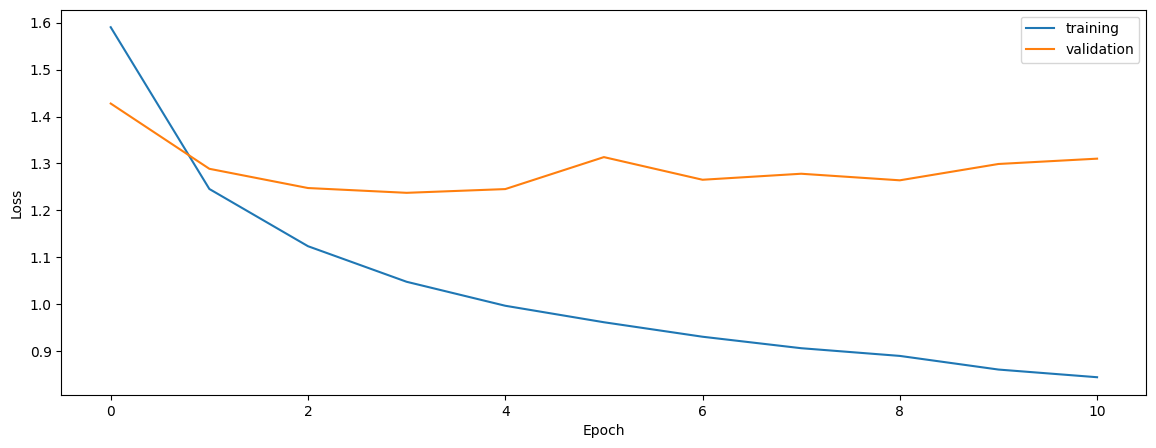

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6043269436659692
0.5415312815034079
0.5247045606757837


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.555446069569066
0.5265585130041903
0.525676629795246


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5721653005464481
0.5416184971098266
0.5500593589236249


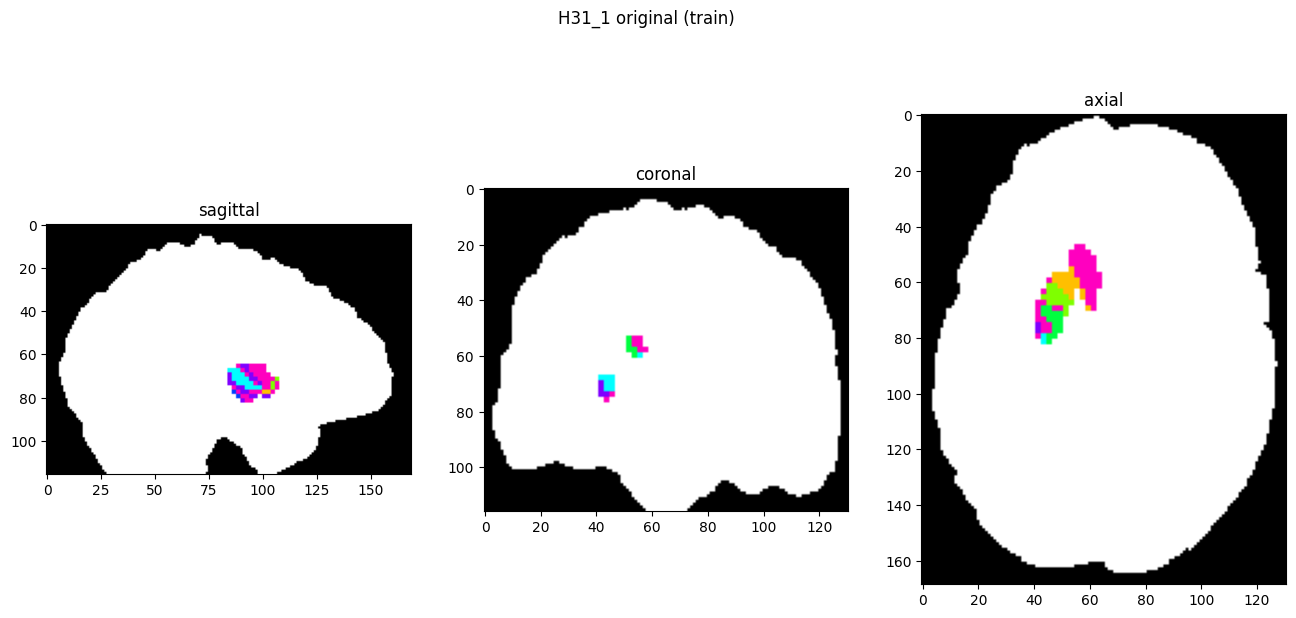

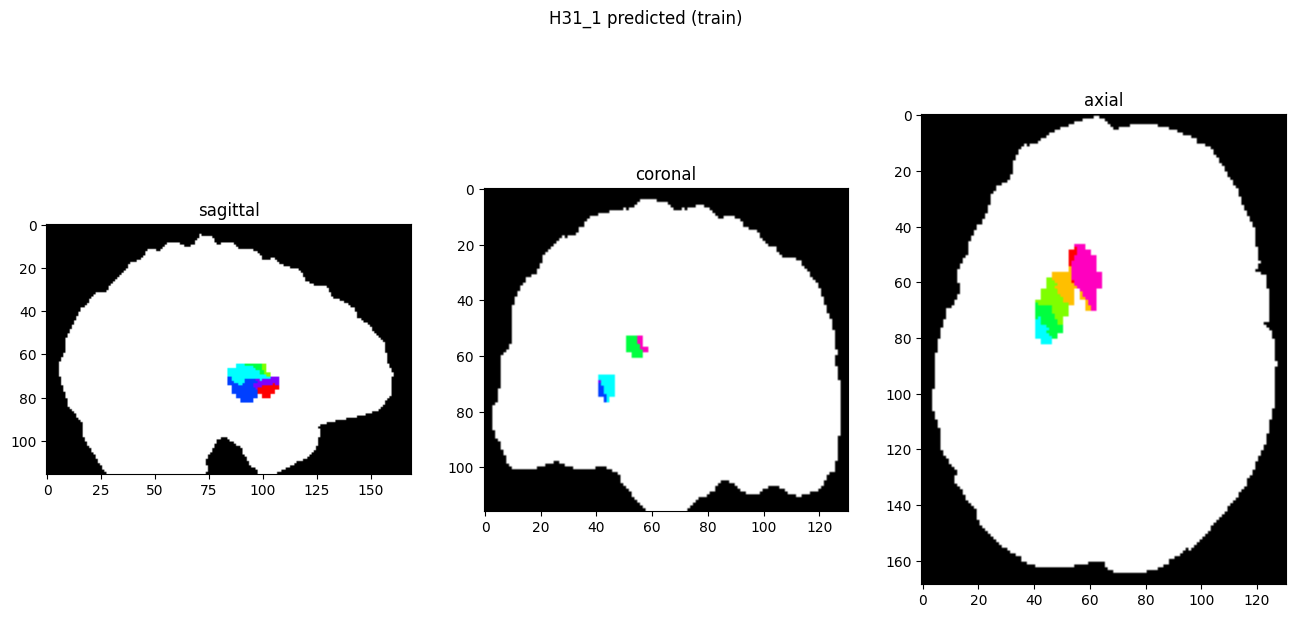

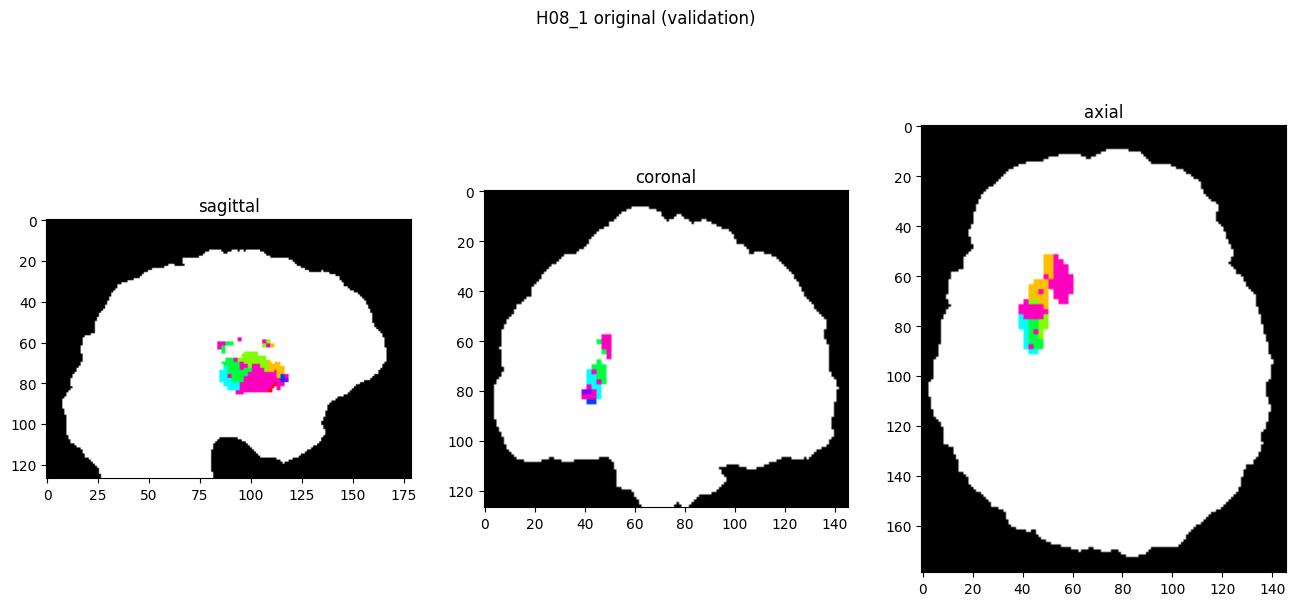

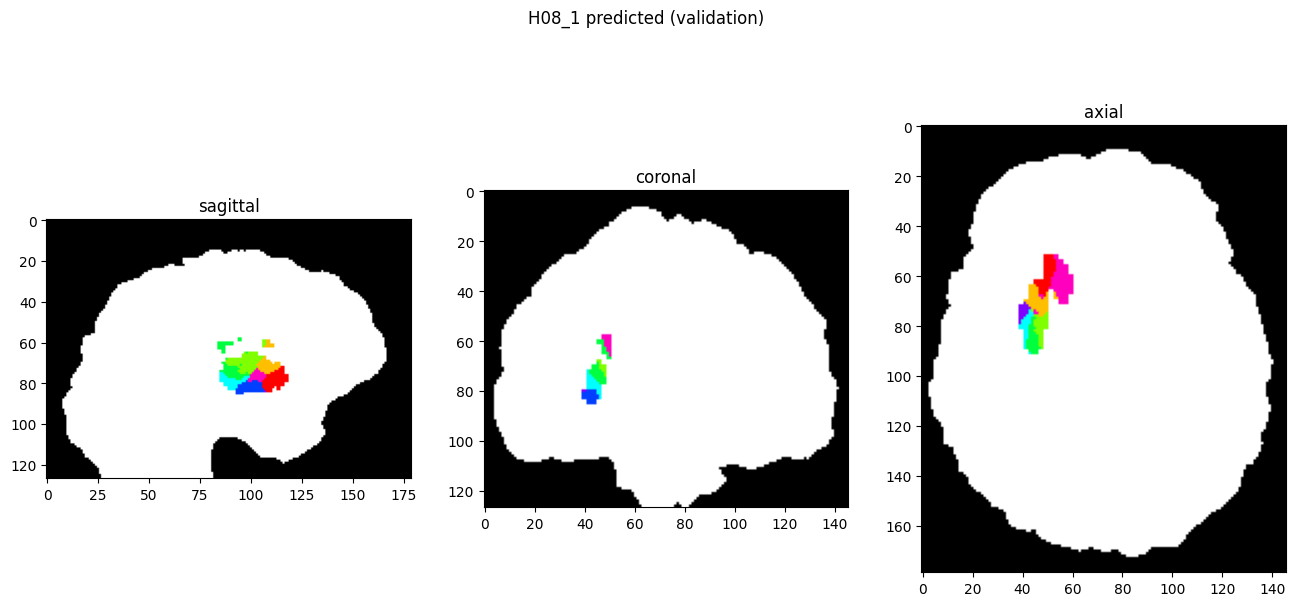

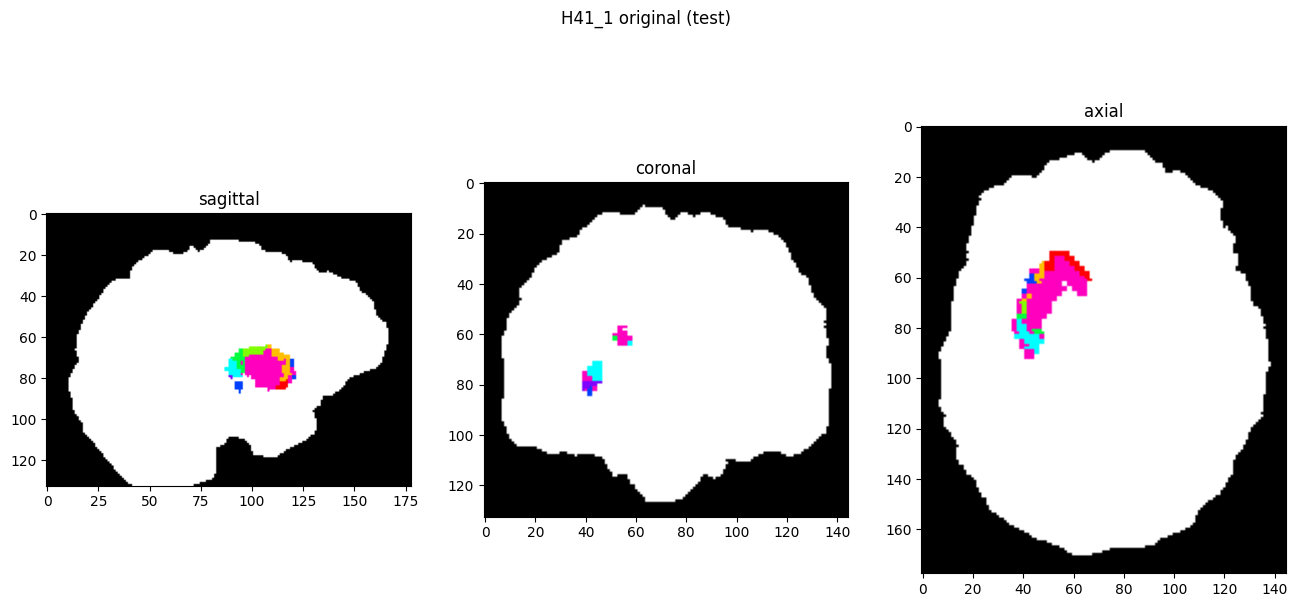

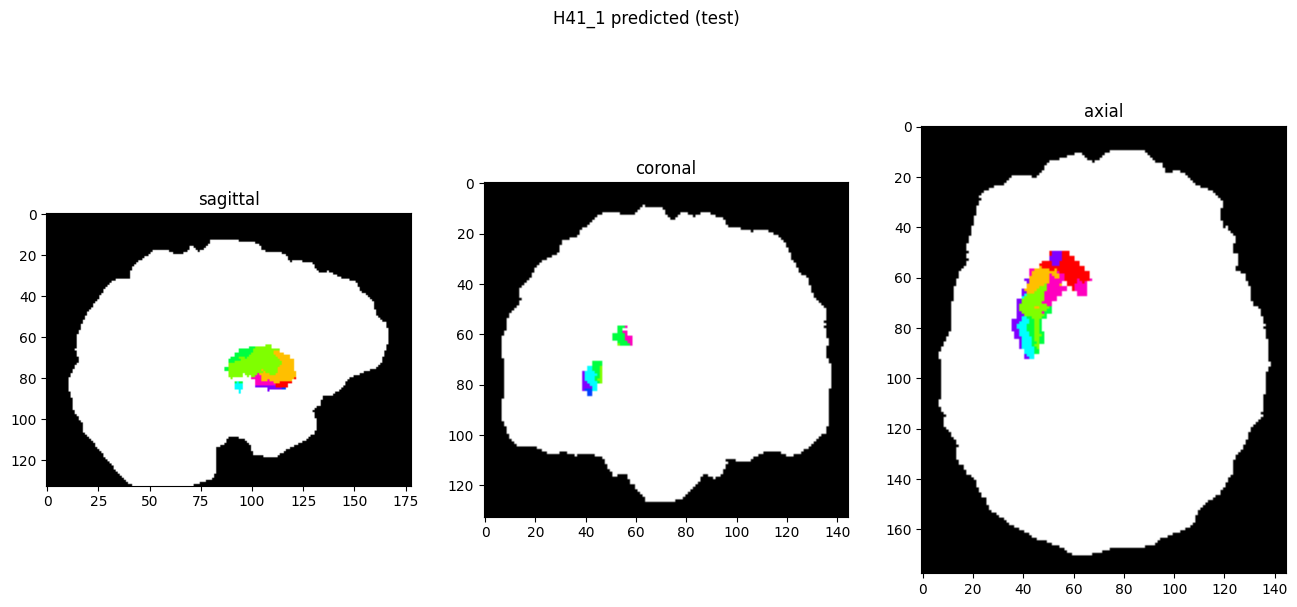

In [10]:
showResults(model, gen, threshold=0)